# GAN
In this notebook, we are going to be focusing on the cycle generative adversarial network in the gan module in PAI-Utils.

## Setup
Let us begin by importing needed packages and getting the Cycle GAN dataset.

### Import Packages

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import Image, display

from paiutils import image
from paiutils import neural_network as nn
from paiutils import gan

# see if using GPU and if so enable memory growth
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Get Cycle GAN Dataset
1. Download the dataset
2. Discard the labels, and resize and scale the images
3. Partition data into train and validation data
4. Create data generator
5. Create a dictionary of the data generator

In [2]:
# Get dataset
cycle_gan = tfds.image_classification.CycleGAN()
cycle_gan.download_and_prepare()
print(cycle_gan.info.features)
print(cycle_gan.info.splits)
data = cycle_gan.as_dataset()

# Split data
train_data_a = data['trainA']
train_data_b = data['trainB']
val_data_a = data['testA']
val_data_b = data['testB']


def preprocess(x):
    # resizing for computational efficiency
    x = tf.image.resize(
        x['image'], (64, 64),
        method=tf.image.ResizeMethod.AREA
    )
    x = (tf.cast(x, tf.float32) / 127.5) - 1
    return x
train_data_a = train_data_a.map(preprocess).batch(len(train_data_a)).as_numpy_iterator().next()
train_data_b = train_data_b.map(preprocess).batch(len(train_data_b)).as_numpy_iterator().next()
val_data_a = val_data_a.map(preprocess).batch(len(val_data_a)).as_numpy_iterator().next()
val_data_b = val_data_b.map(preprocess).batch(len(val_data_b)).as_numpy_iterator().next()
shape = train_data_a.shape[1:]

# The reason we are creating the generators
# instead of using a dataset directly
# is that the data is not
# paired and thus needs 
# to be shuffled.
def train_data_generator(batch_size):
    a_range = np.arange(len(train_data_a))
    b_range = np.arange(len(train_data_b))
    while True:
        a_ndxs = np.random.choice(a_range,
                                  size=batch_size)
        b_ndxs = np.random.choice(b_range,
                                  size=batch_size)
        yield train_data_a[a_ndxs], train_data_b[b_ndxs]

def val_data_generator(batch_size):
    a_range = np.arange(len(val_data_a))
    b_range = np.arange(len(val_data_b))
    y = tf.ones((batch_size, 8, 8, 1))
    while True:
        a_ndxs = np.random.choice(a_range,
                                  size=batch_size)
        b_ndxs = np.random.choice(b_range,
                                  size=batch_size)
        yield (val_data_a[a_ndxs], val_data_b[b_ndxs]), y

batch_size = 32
data = {'train': train_data_generator(batch_size),
        'validation': val_data_generator(batch_size)}

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})
{'testA': <tfds.core.SplitInfo num_examples=266>, 'testB': <tfds.core.SplitInfo num_examples=248>, 'trainA': <tfds.core.SplitInfo num_examples=995>, 'trainB': <tfds.core.SplitInfo num_examples=1019>}


## Create the Model
We will need to make a generative network that will create images and a discriminator network that will be able to determine if an image is real or fake. The CycleGANTrainer will make a copy of these models, so that we have both X and Y generators and discriminators.

In [3]:
x0 = keras.layers.Input(shape=shape)
x1 = nn.conv2d(64, 5, 2)(x0)
x2 = nn.conv2d(128, 3, 2)(x1)
x3 = nn.conv2d(256, 3, 2)(x2)
x4 = nn.conv2d(512, 3, 2)(x3)
x5 = nn.conv2d(512, 3, 2)(x4)
x = nn.conv2d(512, 3, 2, transpose=True)(x5)
#x = keras.layers.Concatenate()([x, x4])
x = nn.conv2d(512, 3, 2, transpose=True)(x)
x = keras.layers.Concatenate()([x, x3])
x = nn.conv2d(256, 3, 2, transpose=True)(x)
x = keras.layers.Concatenate()([x, x2])
x = nn.conv2d(128, 3, 2, transpose=True)(x)
x = keras.layers.Concatenate()([x, x1])
x = nn.conv2d(64, 3, 2, transpose=True)(x)
x = keras.layers.Concatenate()([x, x0])
x = nn.conv2d(64, 5)(x)
output = nn.conv2d(3, 5, 1, activation='tanh',
                   batch_norm=False)(x)
gen_model = keras.Model(inputs=x0, outputs=output)
gen_model.compile(optimizer=keras.optimizers.Adam(.0003, beta_1=.5),
                  loss='mse')
gen_model.summary()


def conv2d(filters, kernel_size, strides, batch_norm=True):
    conv = nn.conv2d(filters, kernel_size=kernel_size,
                     strides=strides, batch_norm=batch_norm,
                     activation=None)
    act = keras.layers.LeakyReLU(alpha=0.2)
    def layer(x):
        x = conv(x)
        x = act(x)
        return x
    return layer

x0 = keras.layers.Input(shape=shape)
x = conv2d(64, 5, 2, batch_norm=False)(x0)
x = conv2d(128, 3, 2)(x)
x = conv2d(256, 3, 2)(x)
x = conv2d(256, 3, 1)(x)
# The GAN Trainer will apply a sigmoid to this output
output = nn.conv2d(1, 3, 1, activation=None, batch_norm=False)(x)
dis_model = keras.Model(inputs=x0, outputs=output)
dis_model.compile(optimizer=keras.optimizers.Adam(.0002, beta_1=.5),
                  loss='binary_crossentropy')
dis_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   4864        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 128)  73856       batch_normalization[0][0]        
_______________________________________________________________________________________

## Train the Model
We can now use the CycleGANTrainer to train the generative and discriminative models on the dataset.

In [4]:
steps_per_epoch = len(train_data_a) // batch_size
trainer = gan.CycleGANTrainer(
    gen_model, dis_model, data,
    idt_loss_coef=5,
    cycle_loss_coef=10
)
trainer.train(100, steps_per_epoch=steps_per_epoch,
              validation_steps=len(val_data_a) // batch_size)
path = trainer.save('')

Epoch 1/100
 2/31 [>.............................] - ETA: 5s - y_gen_loss: 23.4832 - y_adversarial_loss: 0.8709 - y_identity_loss: 0.8587 - y_discriminator_loss: 1.4816 - y_dis_fake_input_loss: 0.6817 - y_dis_real_input_loss: 0.7999 - x_gen_loss: 23.8583 - x_adversarial_loss: 1.0996 - x_identity_loss: 0.8880 - x_discriminator_loss: 1.5581 - x_dis_fake_input_loss: 0.5226 - x_dis_real_input_loss: 1.0355 - cycle_loss: 1.8319WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1057s vs `on_train_batch_end` time: 0.1736s). Check your callbacks.


31/31 [==============================] - 9s 287ms/step - y_gen_loss: 7.5231 - y_adversarial_loss: 0.9009 - y_identity_loss: 0.2361 - y_discriminator_loss: 1.2400 - y_dis_fake_input_loss: 0.6213 - y_dis_real_input_loss: 0.6187 - x_gen_loss: 7.3868 - x_adversarial_loss: 0.8670 - x_identity_loss: 0.2157 - x_discriminator_loss: 1.3113 - x_dis_fake_input_loss: 0.6448 - x_dis_real_input_loss: 0.6665 - cycle_loss: 0.5441 - val_loss: 24.9840 - val_output_1_loss: 11.8234 - val_output_2_loss: 13.1606
Epoch 2/100
31/31 [==============================] - 9s 279ms/step - y_gen_loss: 2.6698 - y_adversarial_loss: 0.9366 - y_identity_loss: 0.0590 - y_discriminator_loss: 1.1877 - y_dis_fake_input_loss: 0.5922 - y_dis_real_input_loss: 0.5955 - x_gen_loss: 2.6636 - x_adversarial_loss: 0.9173 - x_identity_loss: 0.0616 - x_discriminator_loss: 1.1535 - x_dis_fake_input_loss: 0.5839 - x_dis_real_input_loss: 0.5696 - cycle_loss: 0.1438 - val_loss: 24.2739 - val_output_1_loss: 14.7160 - val_output_2_loss: 9.55

31/31 [==============================] - 9s 284ms/step - y_gen_loss: 1.2043 - y_adversarial_loss: 0.7757 - y_identity_loss: 0.0106 - y_discriminator_loss: 1.2935 - y_dis_fake_input_loss: 0.6484 - y_dis_real_input_loss: 0.6451 - x_gen_loss: 1.2045 - x_adversarial_loss: 0.7737 - x_identity_loss: 0.0111 - x_discriminator_loss: 1.3111 - x_dis_fake_input_loss: 0.6519 - x_dis_real_input_loss: 0.6592 - cycle_loss: 0.0376 - val_loss: 19.8498 - val_output_1_loss: 11.2266 - val_output_2_loss: 8.6232
Epoch 34/100
31/31 [==============================] - 9s 284ms/step - y_gen_loss: 1.2077 - y_adversarial_loss: 0.7713 - y_identity_loss: 0.0106 - y_discriminator_loss: 1.3117 - y_dis_fake_input_loss: 0.6518 - y_dis_real_input_loss: 0.6599 - x_gen_loss: 1.1985 - x_adversarial_loss: 0.7610 - x_identity_loss: 0.0108 - x_discriminator_loss: 1.3131 - x_dis_fake_input_loss: 0.6612 - x_dis_real_input_loss: 0.6519 - cycle_loss: 0.0383 - val_loss: 16.2795 - val_output_1_loss: 10.6499 - val_output_2_loss: 5.62

31/31 [==============================] - 9s 284ms/step - y_gen_loss: 1.2625 - y_adversarial_loss: 0.7942 - y_identity_loss: 0.0076 - y_discriminator_loss: 1.2718 - y_dis_fake_input_loss: 0.6346 - y_dis_real_input_loss: 0.6372 - x_gen_loss: 1.2754 - x_adversarial_loss: 0.8047 - x_identity_loss: 0.0081 - x_discriminator_loss: 1.2832 - x_dis_fake_input_loss: 0.6385 - x_dis_real_input_loss: 0.6448 - cycle_loss: 0.0430 - val_loss: 19.2543 - val_output_1_loss: 10.1118 - val_output_2_loss: 9.1425
Epoch 66/100
31/31 [==============================] - 9s 284ms/step - y_gen_loss: 1.2458 - y_adversarial_loss: 0.7972 - y_identity_loss: 0.0075 - y_discriminator_loss: 1.2731 - y_dis_fake_input_loss: 0.6343 - y_dis_real_input_loss: 0.6388 - x_gen_loss: 1.2510 - x_adversarial_loss: 0.7994 - x_identity_loss: 0.0081 - x_discriminator_loss: 1.2924 - x_dis_fake_input_loss: 0.6433 - x_dis_real_input_loss: 0.6492 - cycle_loss: 0.0411 - val_loss: 16.2989 - val_output_1_loss: 10.1756 - val_output_2_loss: 6.12

31/31 [==============================] - 9s 285ms/step - y_gen_loss: 1.2582 - y_adversarial_loss: 0.8064 - y_identity_loss: 0.0075 - y_discriminator_loss: 1.2568 - y_dis_fake_input_loss: 0.6258 - y_dis_real_input_loss: 0.6309 - x_gen_loss: 1.2813 - x_adversarial_loss: 0.8329 - x_identity_loss: 0.0068 - x_discriminator_loss: 1.2309 - x_dis_fake_input_loss: 0.6139 - x_dis_real_input_loss: 0.6170 - cycle_loss: 0.0415 - val_loss: 22.2249 - val_output_1_loss: 14.2037 - val_output_2_loss: 8.0212
Epoch 98/100
31/31 [==============================] - 9s 282ms/step - y_gen_loss: 1.2744 - y_adversarial_loss: 0.8024 - y_identity_loss: 0.0072 - y_discriminator_loss: 1.2628 - y_dis_fake_input_loss: 0.6302 - y_dis_real_input_loss: 0.6326 - x_gen_loss: 1.3420 - x_adversarial_loss: 0.8586 - x_identity_loss: 0.0095 - x_discriminator_loss: 1.2069 - x_dis_fake_input_loss: 0.6037 - x_dis_real_input_loss: 0.6032 - cycle_loss: 0.0436 - val_loss: 18.8382 - val_output_1_loss: 6.2360 - val_output_2_loss: 12.60

## Test the Generators
The model is now trained and saved, so we can test the generative model by using the CycleGANPredictor to create a list of comparisions.

#### Load Generators

In [5]:
# path = 'trained_model4'
x_generator = gan.CycleGANPredictor(path)
y_generator = gan.CycleGANPredictor(path, uses_x_model=False)

x_discriminator = gan.CycleGANPredictor(path, uses_generator=False)
y_discriminator = gan.CycleGANPredictor(path, uses_x_model=False,
                                        uses_generator=False)

#### Display List of Comparisions
We will display the real image, the generated image, the discriminators mask, and the cycled image.

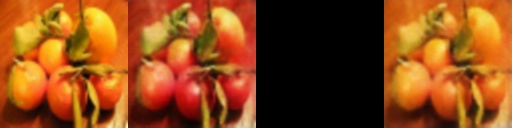

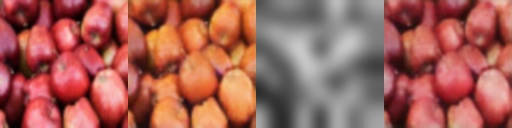

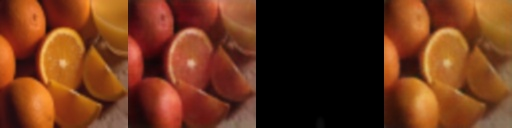

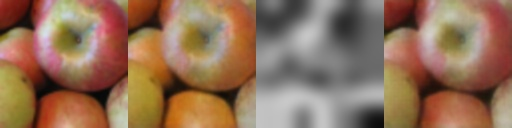

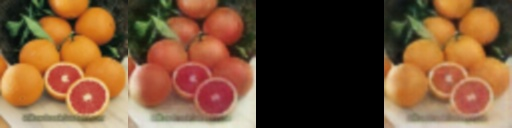

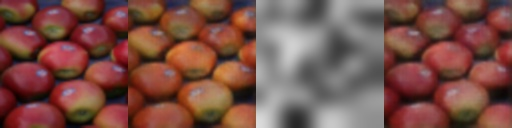

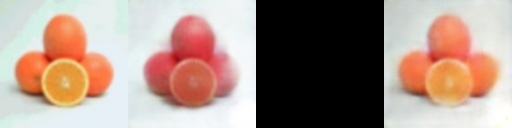

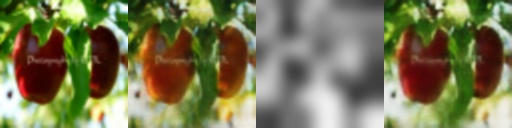

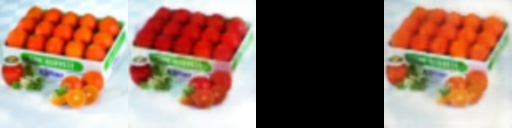

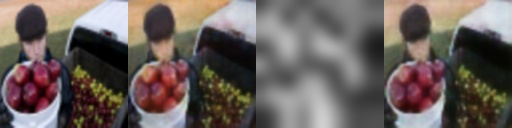

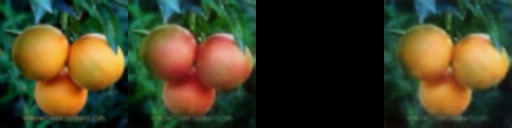

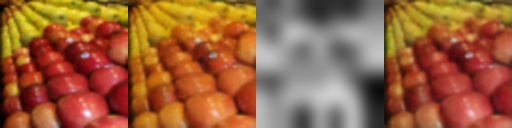

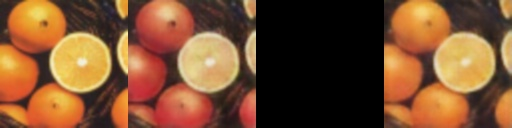

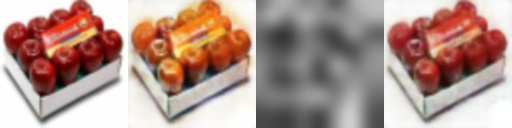

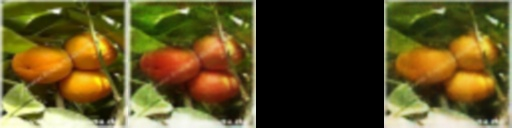

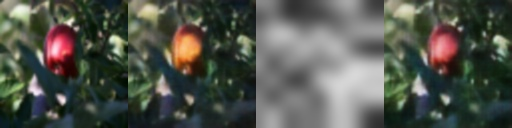

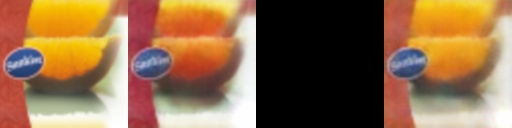

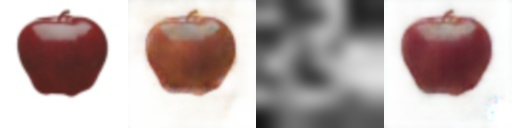

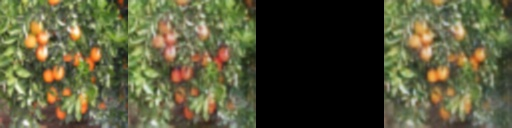

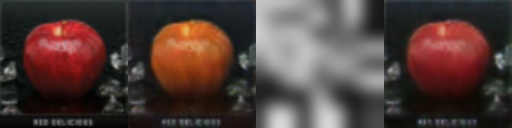

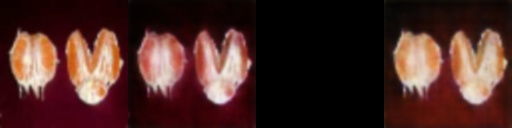

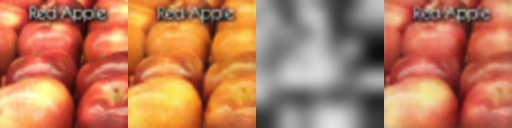

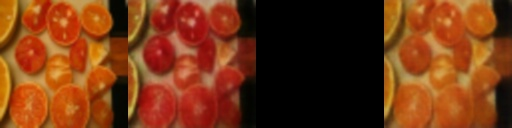

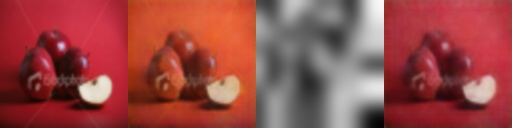

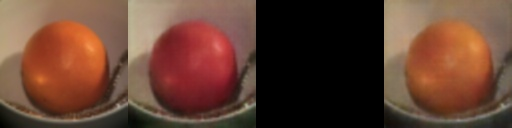

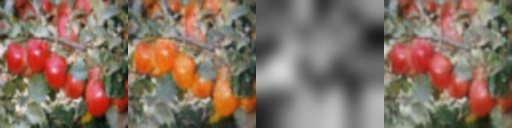

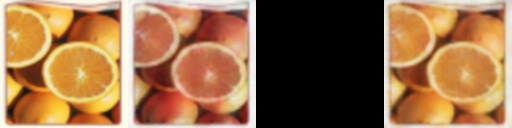

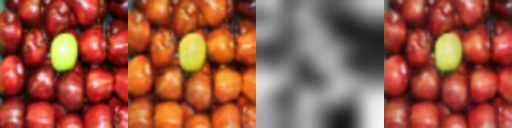

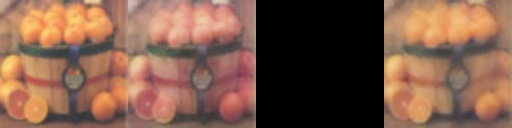

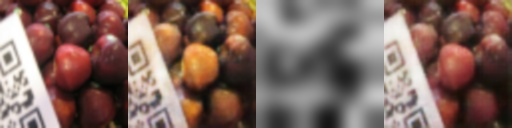

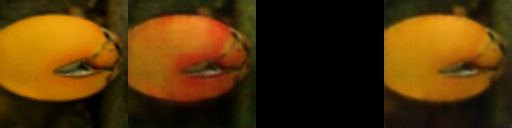

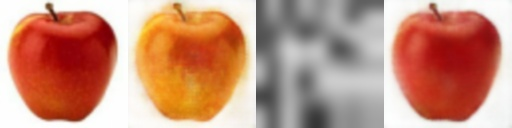

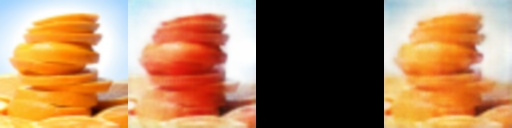

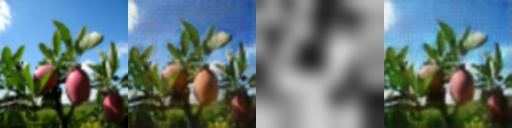

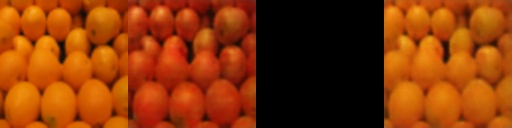

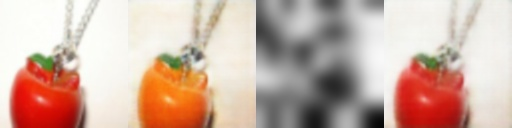

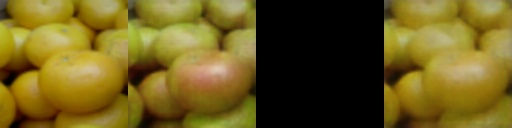

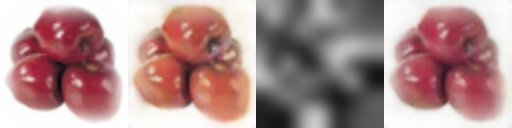

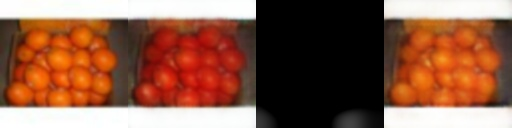

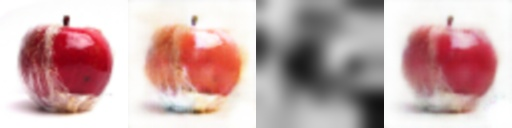

In [6]:
%matplotlib inline
for ndx in range(20):
    x = train_data_a[ndx]
    y = train_data_b[ndx]
    
    x_pred = x_generator.predict(y)
    y_cycled = y_generator.predict(x_pred)
    x_dis = x_discriminator.predict(x_pred)
    x_pred = image.denormalize(x_pred)
    y_cycled = image.denormalize(y_cycled)
    x_dis = (x_dis * 255)[:,:,[0,0,0]]
    
    y_pred = y_generator.predict(x)
    x_cycled = x_generator.predict(y_pred)
    y_dis = y_discriminator.predict(y_pred)
    y_pred = image.denormalize(y_pred)
    x_cycled = image.denormalize(x_cycled)
    y_dis = (y_dis * 255).astype(np.uint8)[:,:,[0,0,0]]
    
    x = image.denormalize(x)
    y = image.denormalize(y)
    img1 = np.hstack([image.pyr(y, 1), image.pyr(x_pred, 1), image.pyr(x_dis, 4), image.pyr(y_cycled, 1)])
    img2 = np.hstack([image.pyr(x, 1), image.pyr(y_pred, 1), image.pyr(y_dis, 4), image.pyr(x_cycled, 1)])

    # swap bgr to rgb
    img1 = img1[:,:,::-1]
    img2 = img2[:,:,::-1]
    
    ret = image.cv2.imencode('.jpg', img1)[1]
    display(Image(data=ret))
    ret = image.cv2.imencode('.jpg', img2)[1]
    display(Image(data=ret))